# Import modules needed

In [1]:
import numpy as np
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from tqdm import tqdm

# Functions

These functions below deal with the Elmegreen fractal generating algorithm itself.

The funtion `coord_func` is equivalent to the equation:

$$
x_n = x_{n-1} + \frac{|2\mathcal{L} - 1 |}{\mathcal{S}^g}
$$

where $\mathcal L$ is a linear random deviate on the interval $[0,1]$, $\mathcal S$ is the scaling parameter as described by Elmegreen (1997), and $g$ is the generation. This function generates $\mathcal F$ values of $x_n$, described as the number of children.

The function `fractal_point_gen` defines the logic needed to generate the points which constitute the fractal field. The `integer` parameter let's the function decide whether we want an integer $\mathcal S$ (`integer='S'`) or an integer $\mathcal F$ (`integer ='F'`). Subsequently, the function has the optional parameters `S` and `F`, one of which must be defined depending on the choice of `integer`. The function also takes as parameters; the number of generations $\mathcal G$, the fractal dimension, $D$, and the Euclidean dimension, $E$.

If we want an integer $\mathcal S$ the function calculates, $\mathcal{F}$, $\mathcal{F}_{\rm{ST}}$, $\mathcal{F}_{\rm{LO}}$, $\mathcal{F}_{\rm{HI}}$, and $\Delta\mathcal{F}$. It then sets up the appropriate values of $\mathcal{F}$ and $\mathcal G$ with which to pass to `coord_func`. The first $\mathcal F$ value is equal to $\mathcal{F}_{\rm{ST}}$, the rest are set as follows:

\begin{eqnarray}
{\cal F}_{_{\rm{LO}}}\,,&{\rm{if}}&{\cal L}>\Delta{\cal F}\,,\\
{\cal F}_{_{\rm{HI}}}\,,&{\rm{if}}&{\cal L}<\Delta{\cal F}\,.
\end{eqnarray}

A set of points are generated $E$ times to get an $E$-dimensional set of coordinates.

`fractal_point_gen` also has the option to pass these coordinates to the `star_culling` function before returning them.

The function `star_culling` takes a set of coordinates and culls points randomly to a desired number.

The function `fractal_field_gen` returns a histogram based on `fractal_point_gen`.

In [2]:
def coord_func(x,S,g,F):
    L = np.random.random(F)
    return x + 2*(L-0.5)/S**g

def fractal_point_gen(integer,G,D,E=2,S=None,F=None,N_points=None):
    if integer == 'S':
        F=S**D
        F_st = int(F+0.5)
        F_lo = int(F)
        F_hi = F_lo+1
        F_change = F - F_lo
        L = np.random.random(G-1)
        F_array = np.concatenate((np.array([F_st]),np.where(L>F_change,F_lo,F_hi)),axis=None)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g,f in np.array([G_array,F_array]).T:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,f)]
            points.append(x)
    if integer == 'F':
        S=F**(1/D)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g in G_array:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,F)]
            points.append(x)
    if N_points:
        points = star_culling(points,N_points)
    return points

def star_culling(points, N_points):
    while len(points[0])>N_points:
            n=1+int(np.random.random()*(len(points[0])-1))
            del points[0][n-1]
            del points[1][n-1]
    return points

def fractal_field_gen(integer,G,D,E,S=None,F=None,N_pix=None,seed=None):
    if seed != None:
        np.random.seed(int(seed))  
    if N_pix==None:
        N_pix = S**G
    fractal_points = fractal_point_gen(integer,G,D,E,S,F)
    fractal_field = np.histogramdd(fractal_points, bins=int(N_pix))[0]
    return fractal_field

The functions below deal with calculating the cumulative probability distribution for the separations of a set of points.

Given a set of $\cal I$ stars, where each star has position $\mathbf r_i \equiv (x_i,y_i)$, the cumulative probability probability distribution is,

$$P(s) \simeq \frac{2\cal N(<s)}{\cal I (\cal I -1)}$$

where $\cal N(<s)$ is the number of separations less than $s$. 

This requires us to compute all inter-star separations,

$$s_{ij} = \big|\mathbf r_i - \mathbf r_j\big|$$

making sure we only count each separation once.

The function `ordered_separations` computes all the unique separations for a set of points.

The function `two_pt_corr` takes a set of points, its separations, and the value $s$ and computes the cumulative probability that a separation is less than $s$.

In [3]:
def ordered_separations(points):
    coords = [(point[0], point[1]) for point in np.array(points).T]
    distance_matrix = distance.cdist(coords, coords, 'euclidean')
    separations = np.unique(distance_matrix[distance_matrix != 0])
    return separations

def two_pt_corr(coords,separations,s):
    N_s = np.sum(np.where(separations<s,1,0))
    I=len(coords)
    P_s = 2*N_s/(I*(I-1))
    return P_s

# Integer S

In [4]:
N_fields = 10
S_LIST=[2,3]*N_fields
D = 2.3
G_LIST = [6,4]*N_fields
E=2

params = np.array([S_LIST,G_LIST]).T
params[:10]

array([[2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4],
       [2, 6],
       [3, 4]])

In [5]:
star_fields = [fractal_point_gen('S',g,D,E,S=s) for s,g in params]
sizes_fields= np.array([len(field[0]) for field in star_fields])
min_stars = np.min(sizes_fields)
culled_star_fields = [star_culling(field, min_stars) for field in star_fields]
len(culled_star_fields)

20

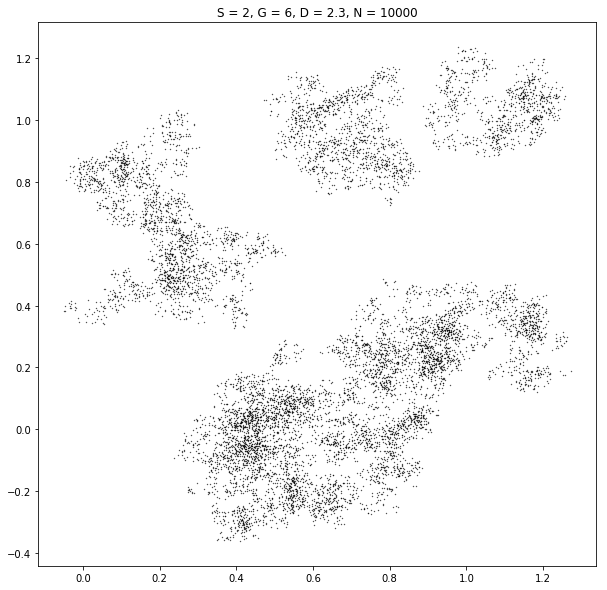

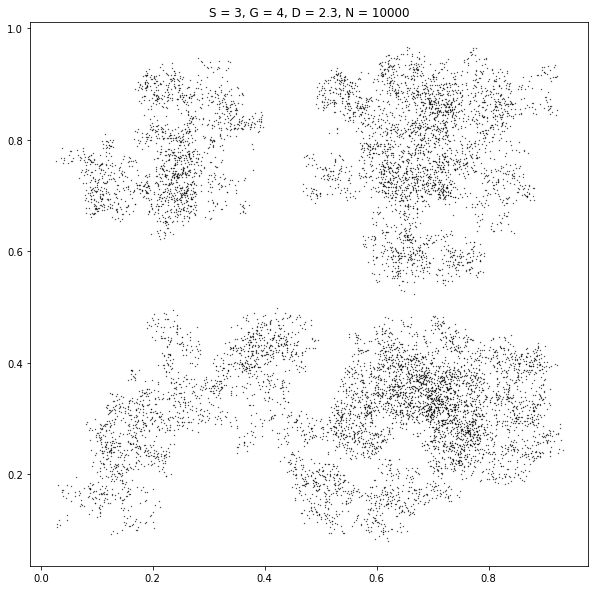

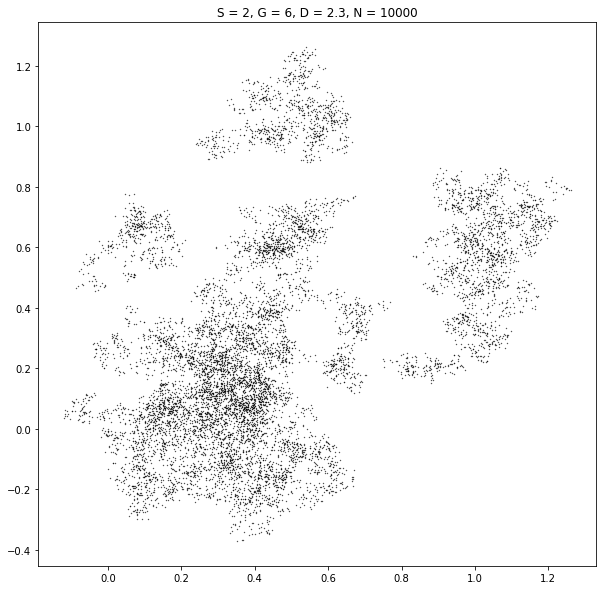

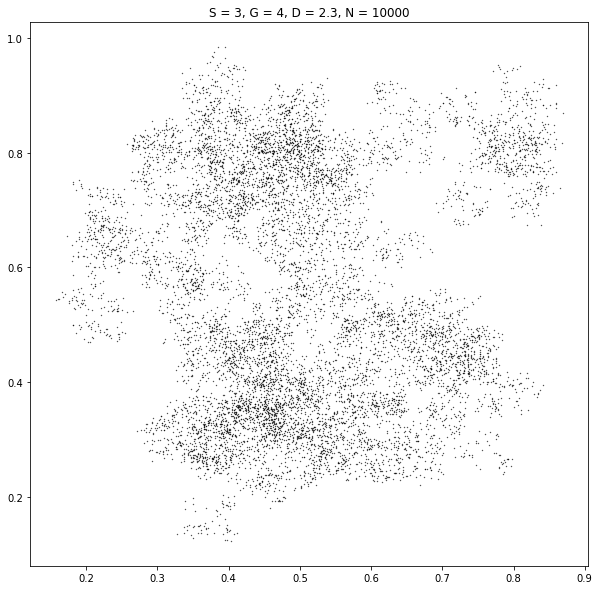

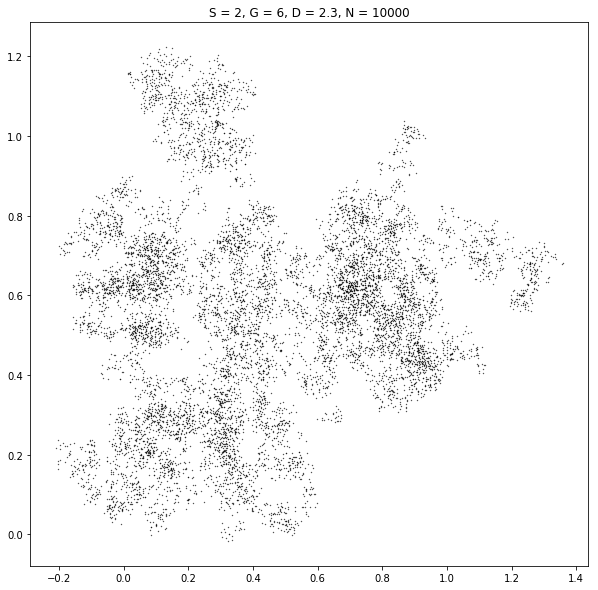

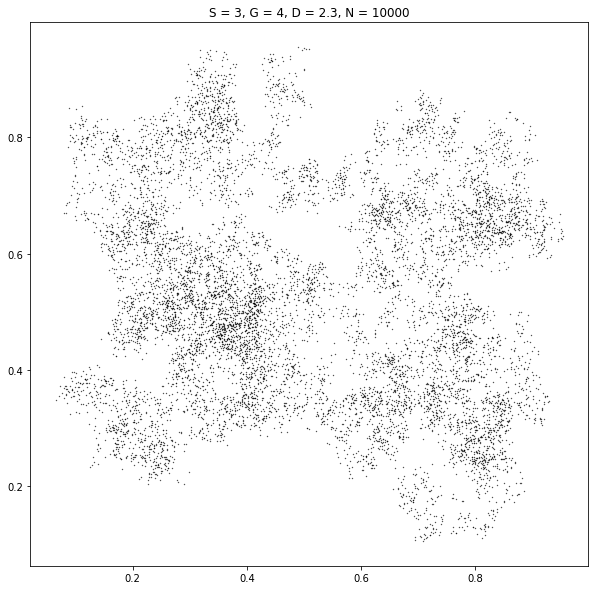

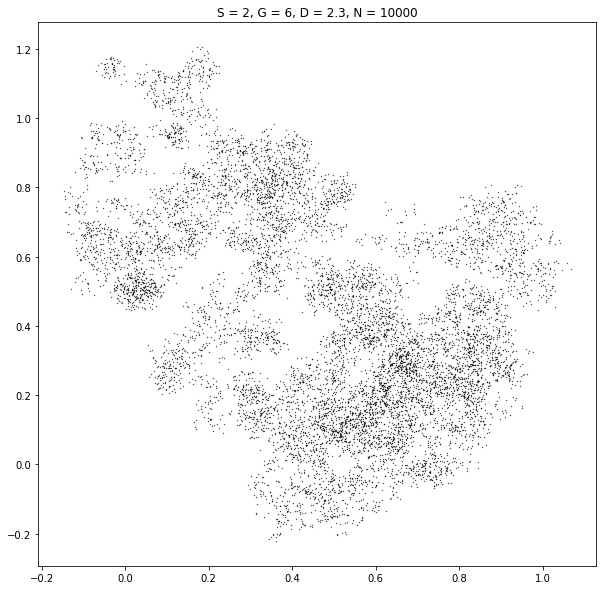

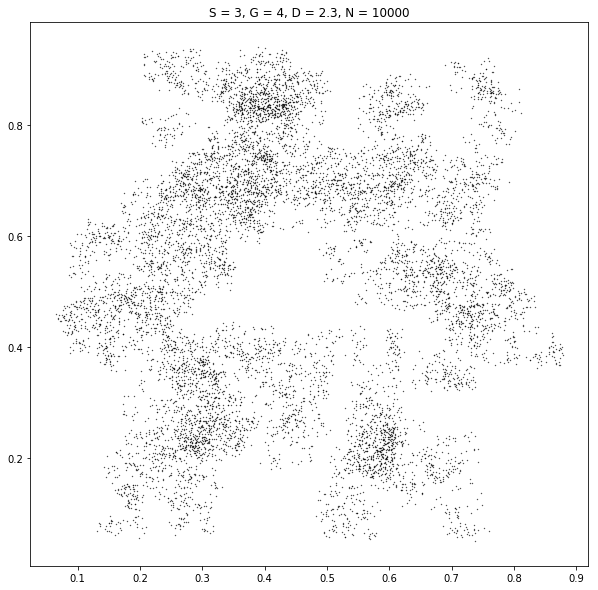

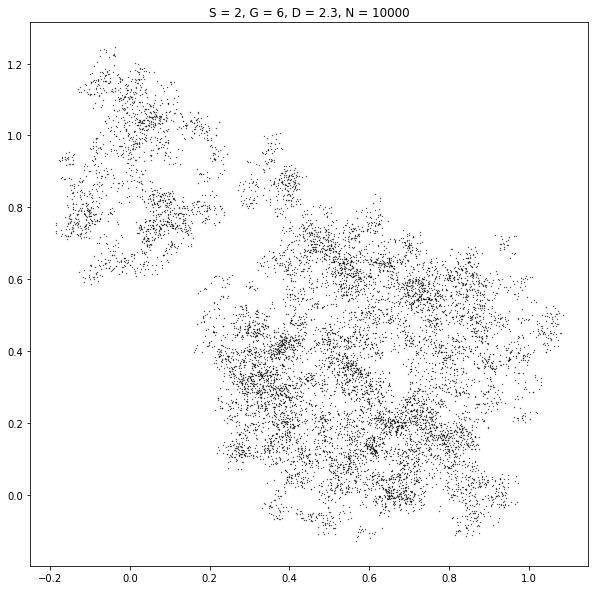

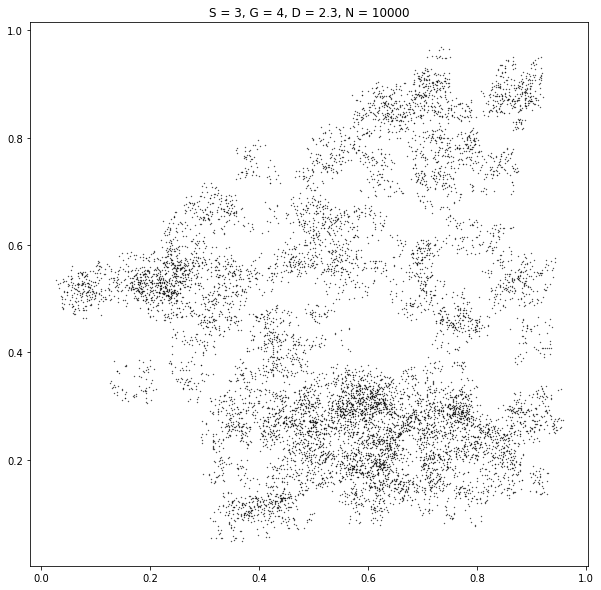

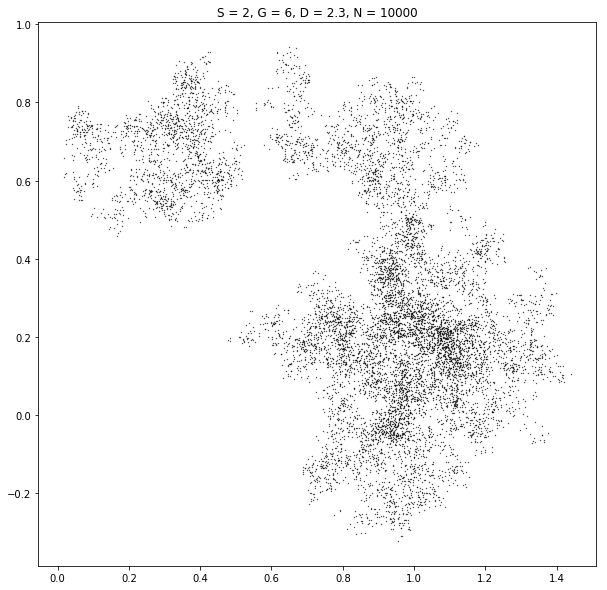

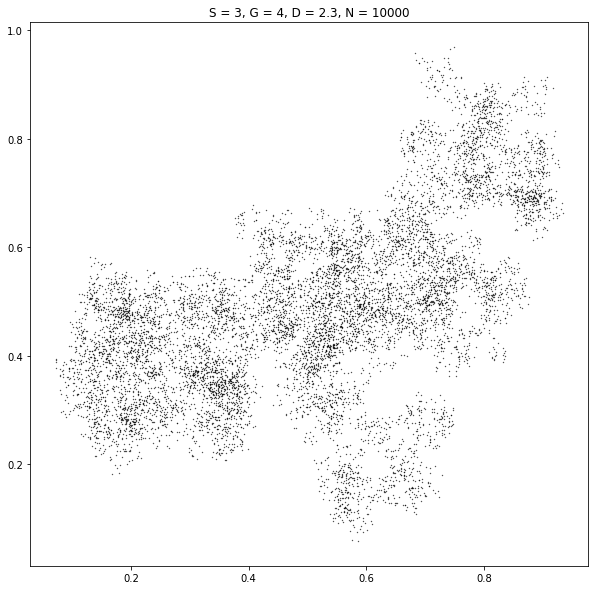

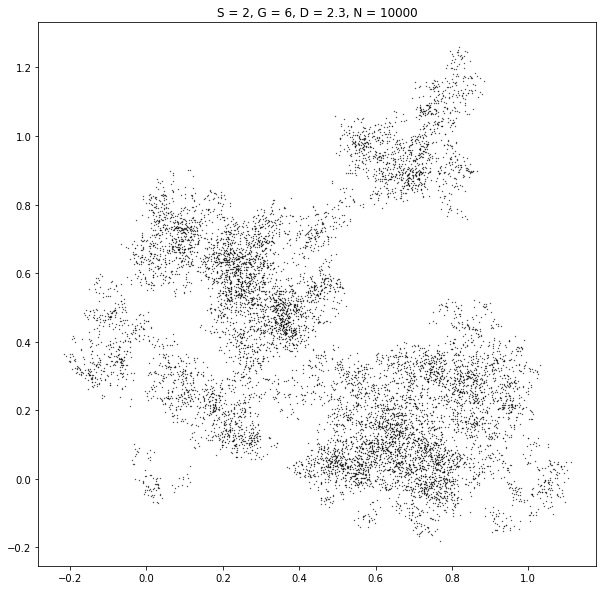

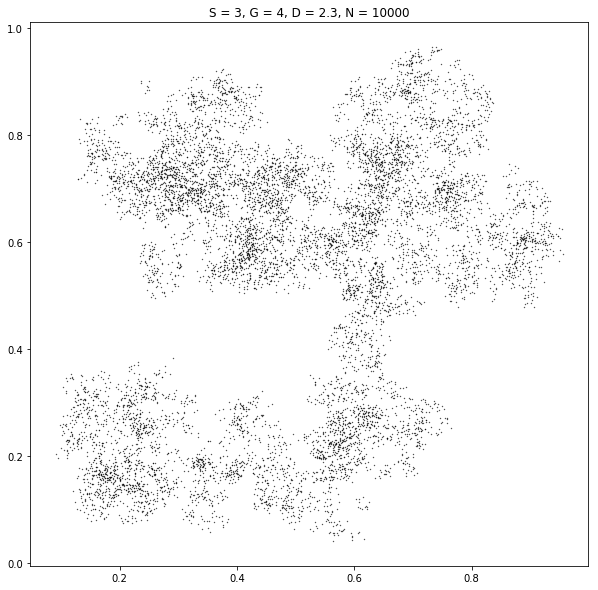

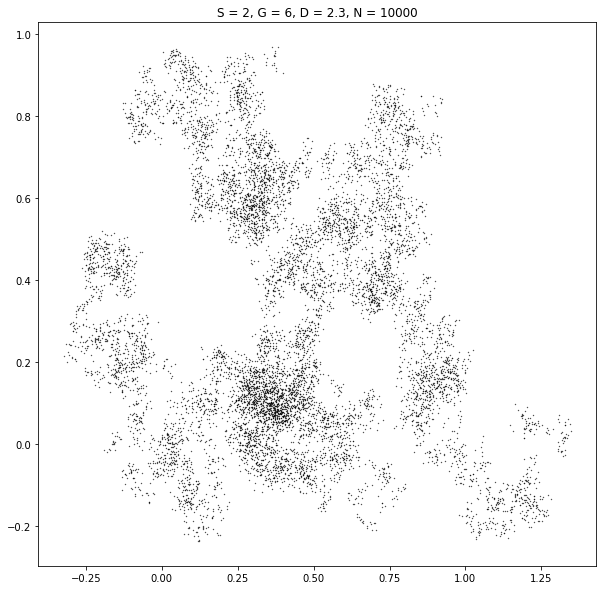

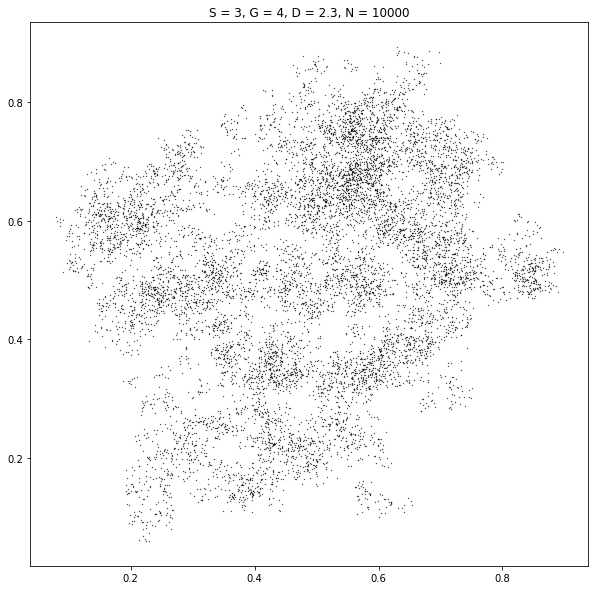

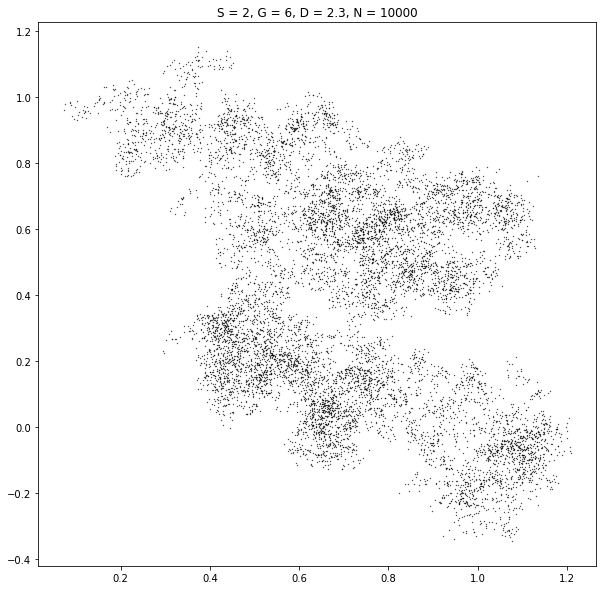

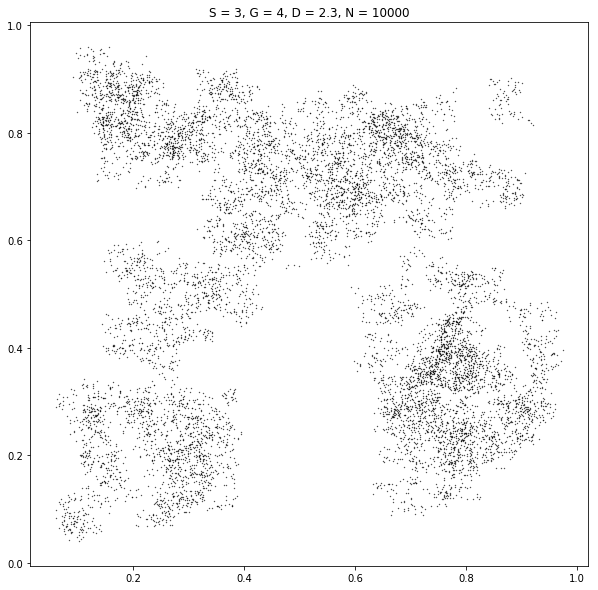

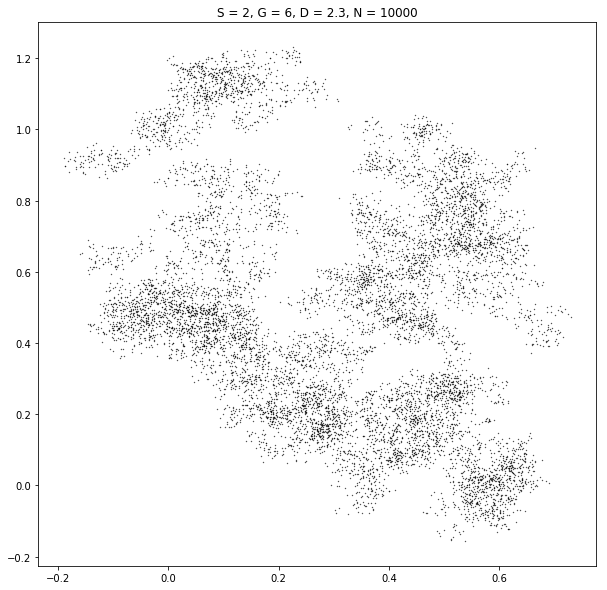

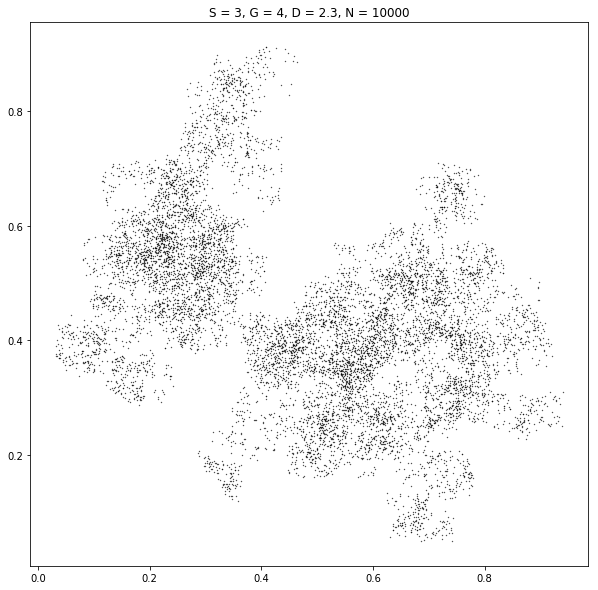

In [6]:
for i,field in enumerate(culled_star_fields):
    plt.figure(figsize=(10,10))
    #plt.hist2d(*field, bins=128)
    plt.title('S = {}, G = {}, D = {}, N = {}'.format(S_LIST[i],G_LIST[i],D,len(field[0])))
    plt.scatter(*field, s=.1, c='k')
    plt.show()

In [7]:
separations_list = [ordered_separations(field) for field in tqdm(culled_star_fields)]
len(separations_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:19<00:00, 16.10s/it]


20

In [8]:
s_factors = np.linspace(0.7,2,10)
P_s_list = [[two_pt_corr(culled_star_fields[i],seps,s) for s in s_factors] for i,seps in enumerate(tqdm(separations_list))]
len(P_s_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  8.04s/it]


20

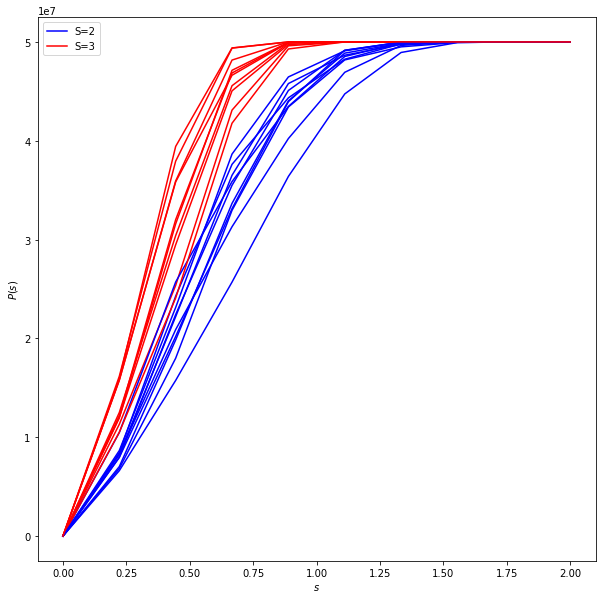

In [9]:
plt.figure(figsize=(10,10))
plt.plot([], label='S=2', color="blue")  
plt.plot([], label="S=3", color="red")  
for i,P_s in enumerate(P_s_list):
    S=params[i][0]
    G=params[i][1]
    if S==2:
        plt.plot(s_factors,P_s, c='b')
    if S==3:
        plt.plot(s_factors,P_s, c='r')
plt.ylabel(r'$P(s)$')
plt.xlabel(r'$s$')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.show()

# Integer F

In [16]:
def calc_G(F_2,F_1=5,G_1=6):
    return int(np.ceil(G_1*np.log(F_1)/np.log(F_2)))

N_fields = 1
F_LIST=[*range(4,15+1)]*N_fields
D = 2.3
G_LIST = [calc_G(f) for f in F_LIST]
E=2

params = np.array([F_LIST,G_LIST]).T
params[:10]

array([[ 4,  7],
       [ 5,  6],
       [ 6,  6],
       [ 7,  5],
       [ 8,  5],
       [ 9,  5],
       [10,  5],
       [11,  5],
       [12,  4],
       [13,  4]])

In [17]:
star_fields = [fractal_point_gen('F',g,D,E,F=f) for f,g in params]
#sizes_fields= np.array([len(field[0]) for field in star_fields])
#min_stars = np.min(sizes_fields)
culled_star_fields = [star_culling(field, min_stars) for field in star_fields]
print(sizes_fields)

[12500 26364 10000 24336 12500 26364 15625 26364 12500 26364 12500 28561
 15625 22464 15625 26364 15625 28561 12500 26364]


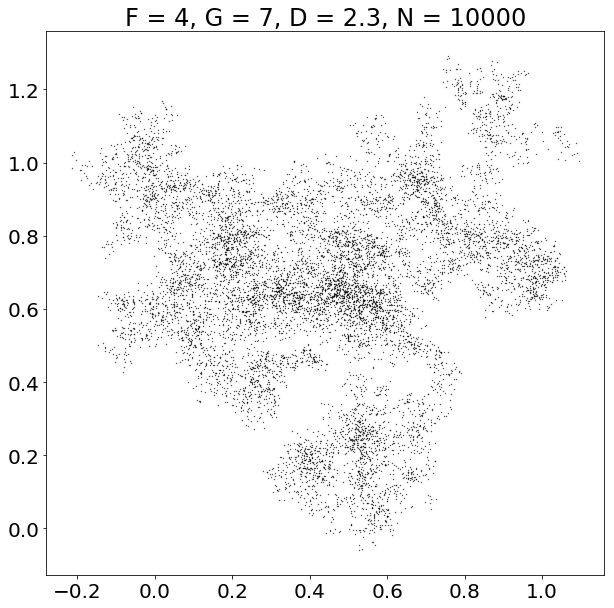

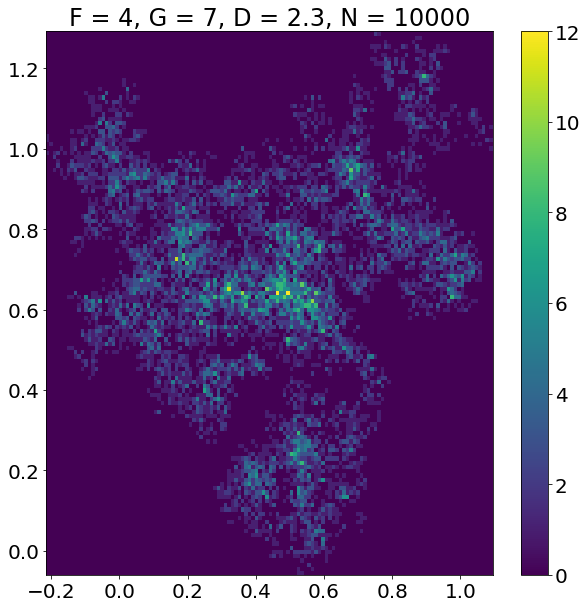

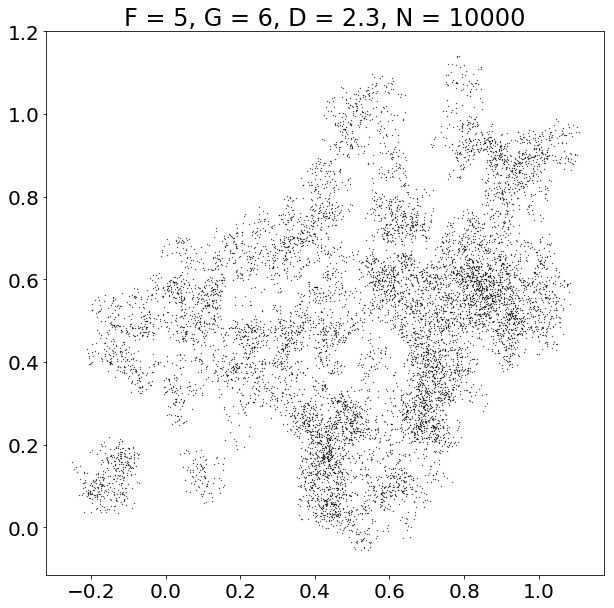

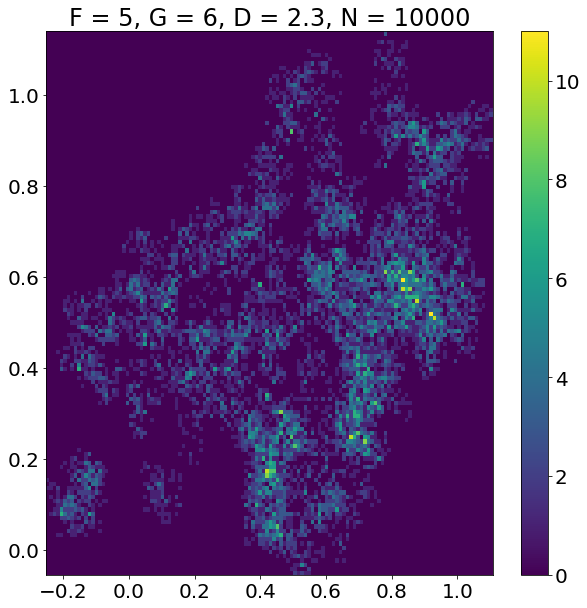

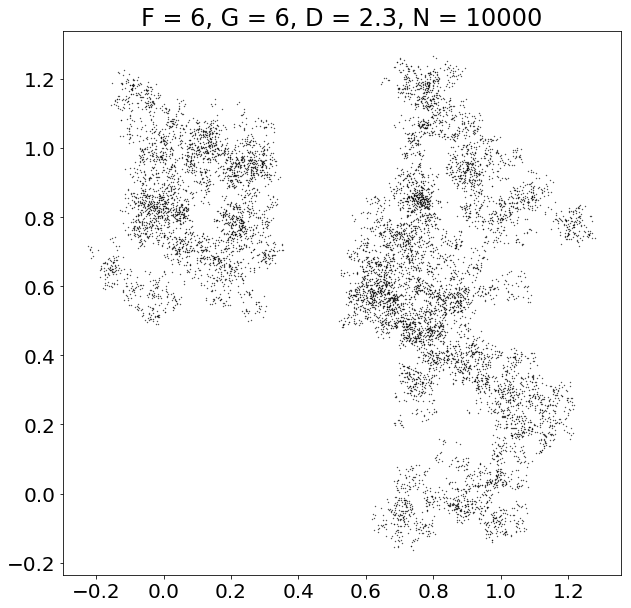

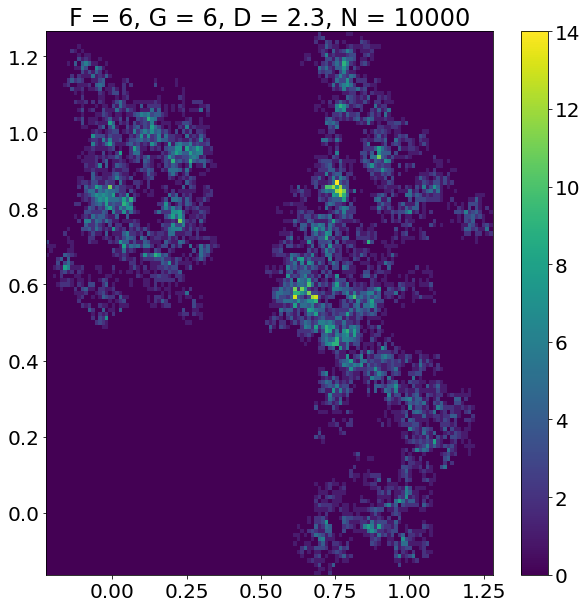

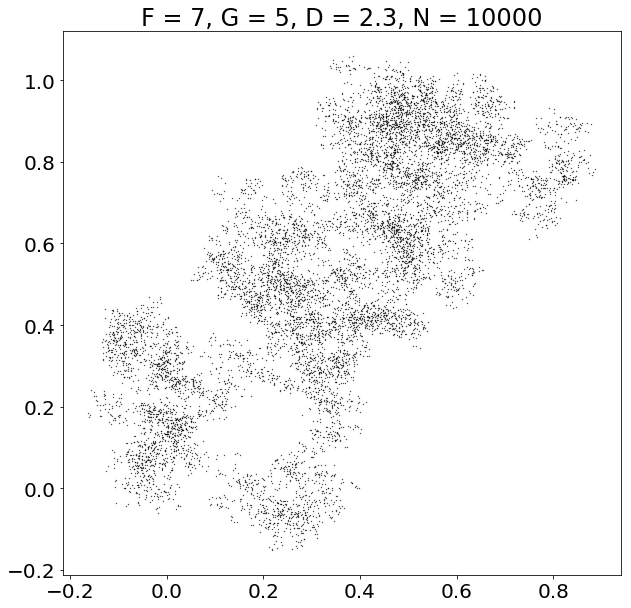

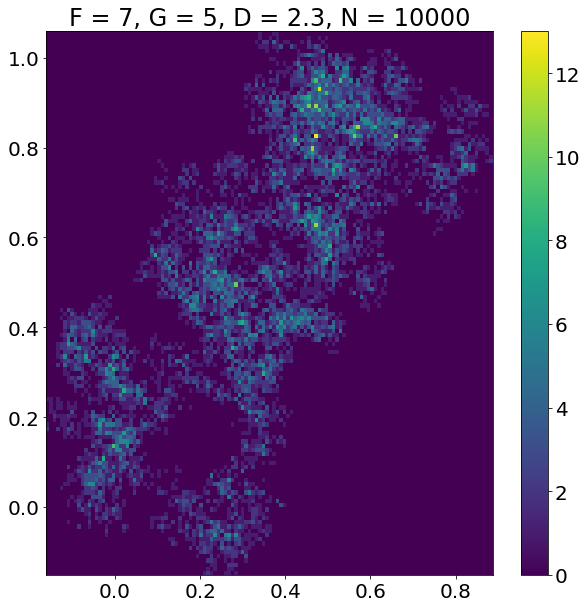

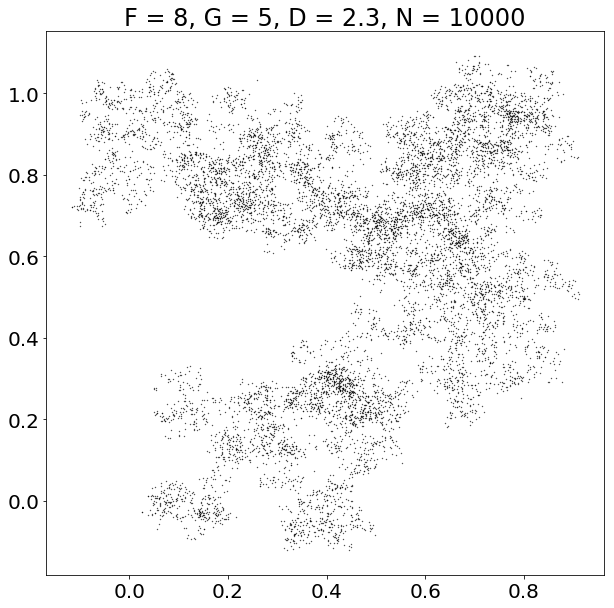

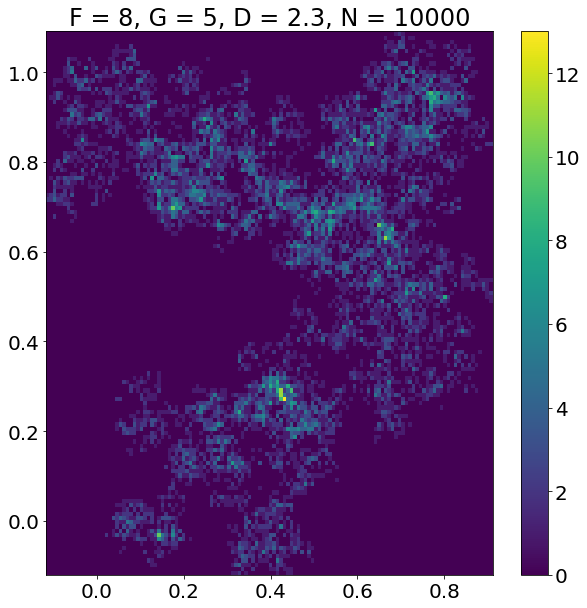

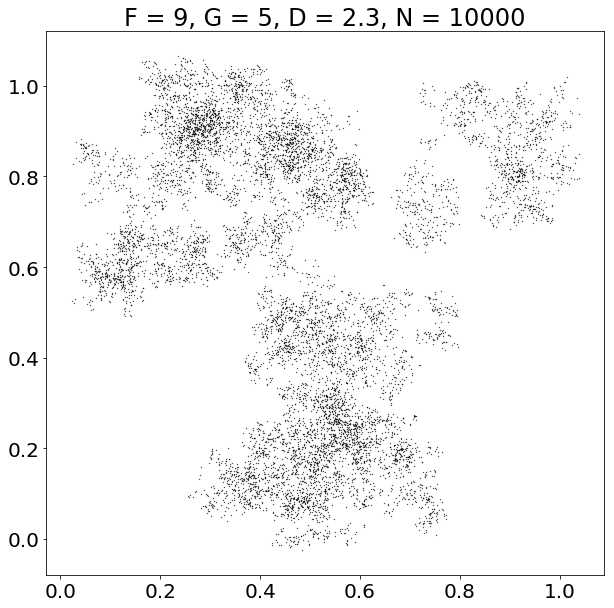

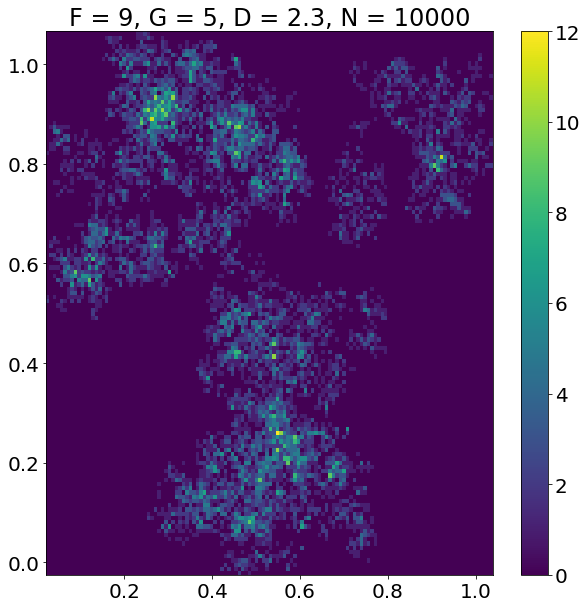

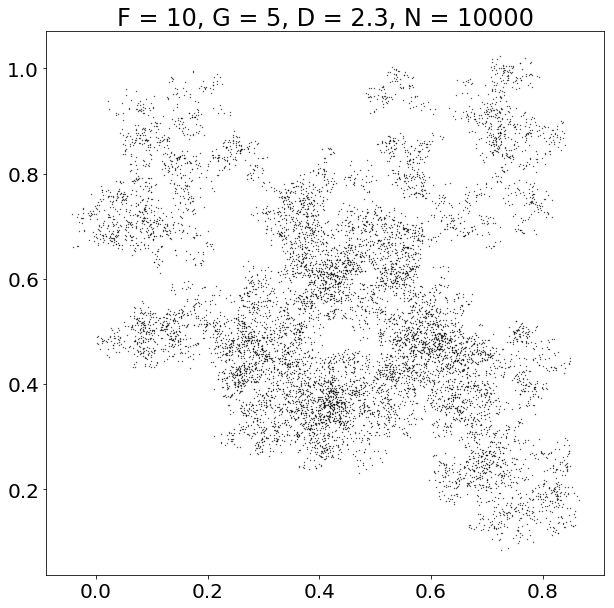

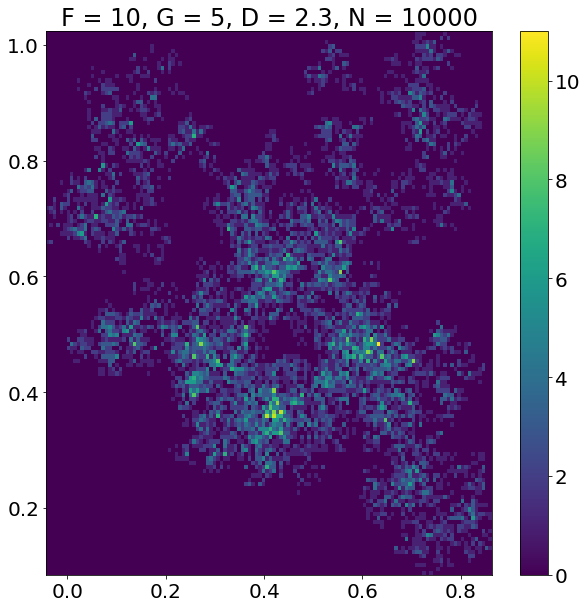

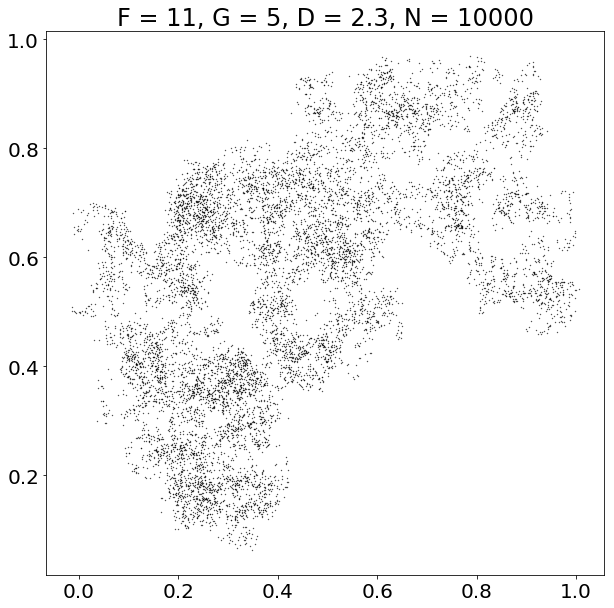

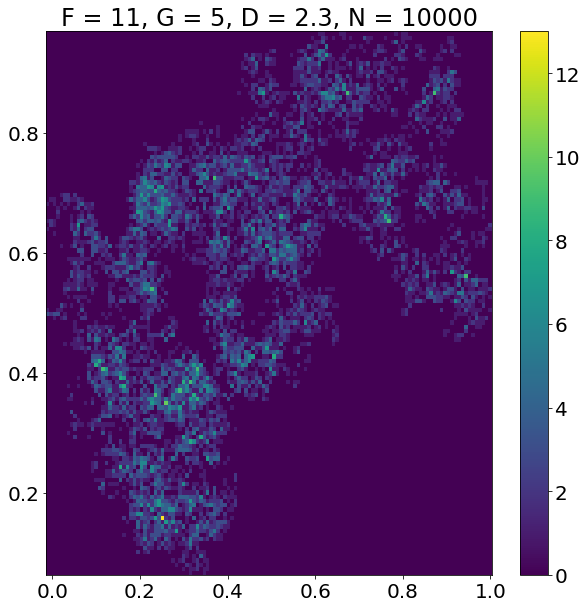

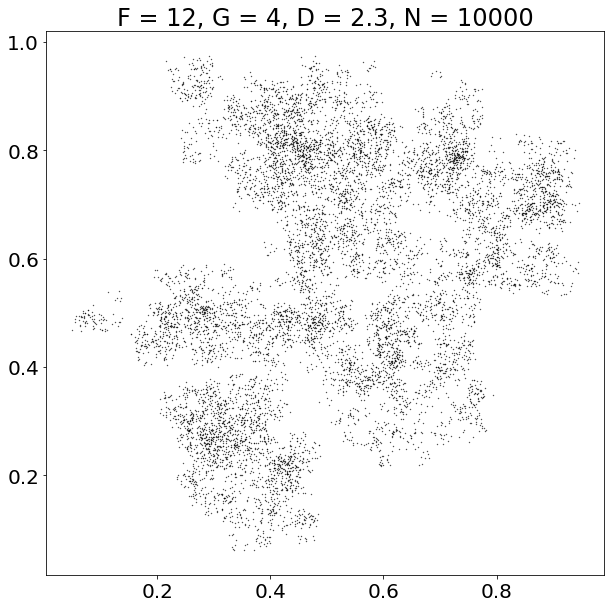

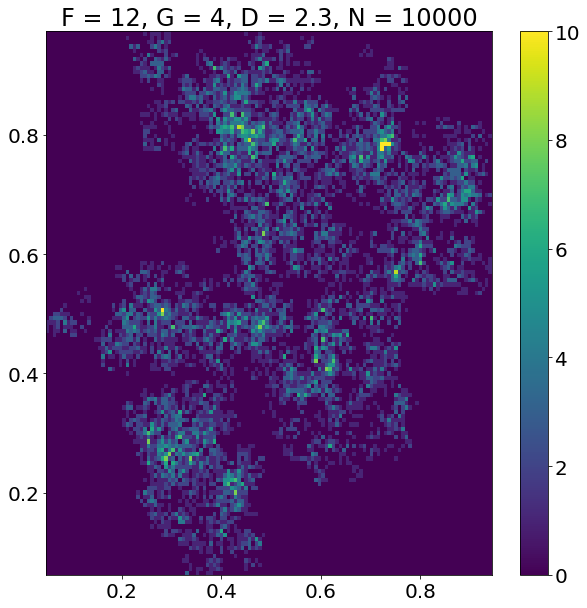

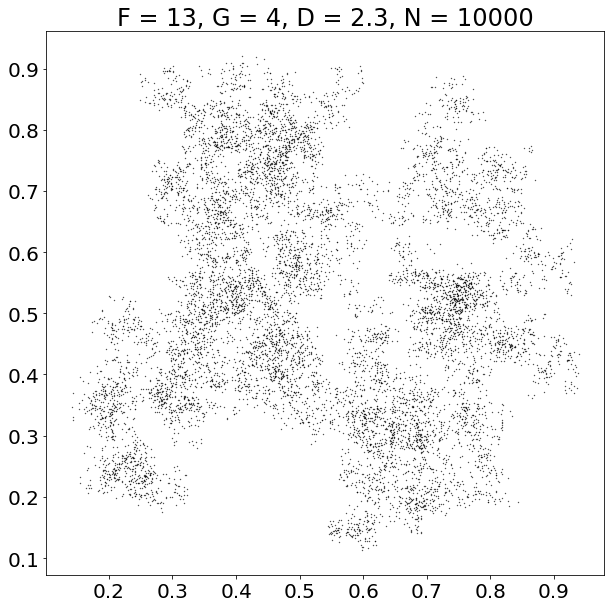

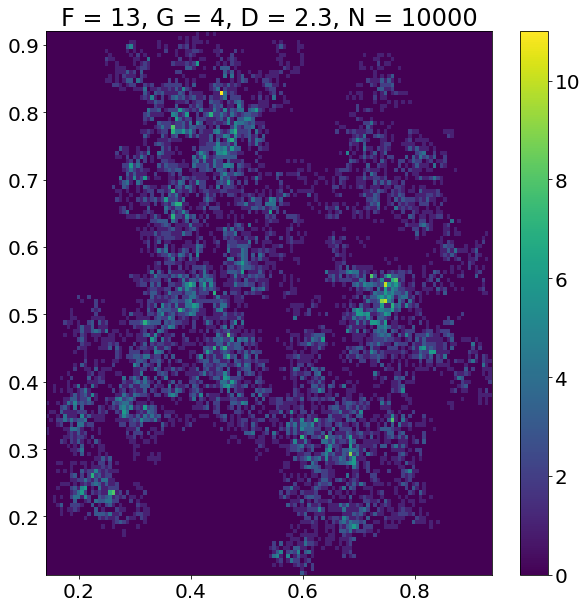

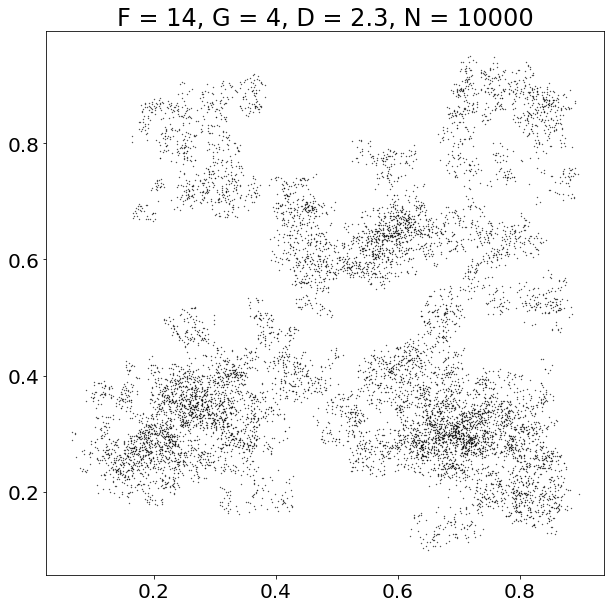

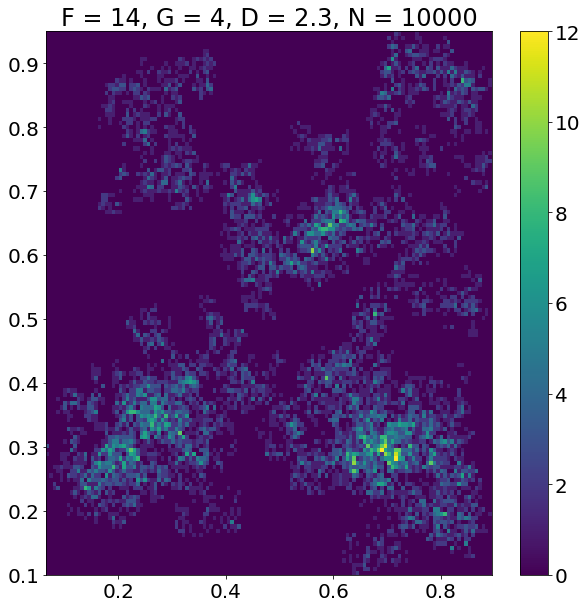

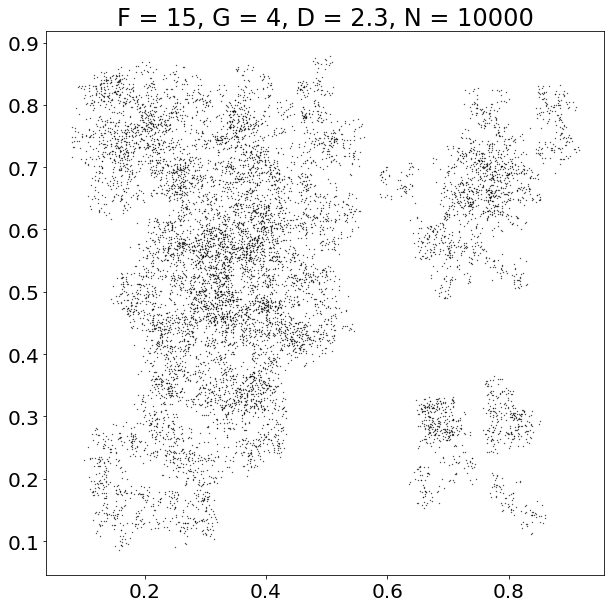

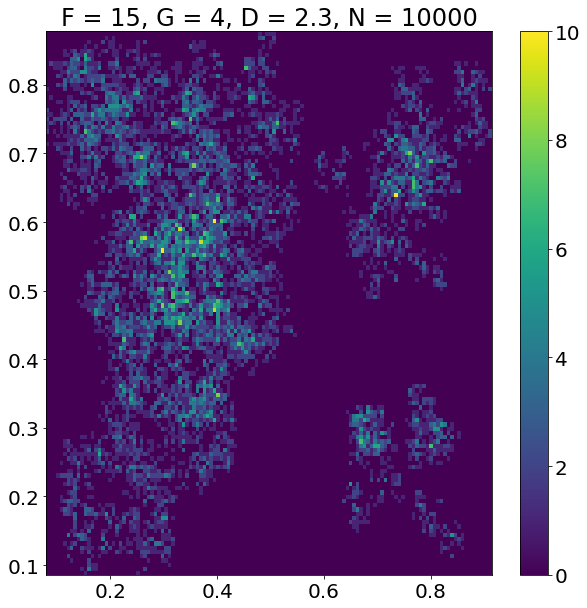

In [60]:
for i,field in enumerate(culled_star_fields):
    plt.figure(figsize=(10,10))
    #plt.hist2d(*field, bins=128)
    plt.title('F = {}, G = {}, D = {}, N = {}'.format(F_LIST[i],G_LIST[i],D,len(field[0])))
    plt.scatter(*field, s=.1, c='k')
    plt.show()    
    
    plt.figure(figsize=(10,10))
    plt.hist2d(*field, bins=128)
    plt.title('F = {}, G = {}, D = {}, N = {}'.format(F_LIST[i],G_LIST[i],D,len(field[0])))
    plt.colorbar()
    #plt.scatter(*field, s=.1, c='k')
    plt.show()

In [19]:
separations_list = [ordered_separations(field) for field in tqdm(culled_star_fields)]
len(separations_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [03:13<00:00, 16.31s/it]


12

In [29]:
s_factors = np.linspace(0,1.75,100)
P_s_list = [[two_pt_corr(culled_star_fields[i],seps,s) for s in s_factors] for i,seps in enumerate(tqdm(separations_list))]
len(P_s_list)


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [06:39<00:00, 32.77s/it]


12

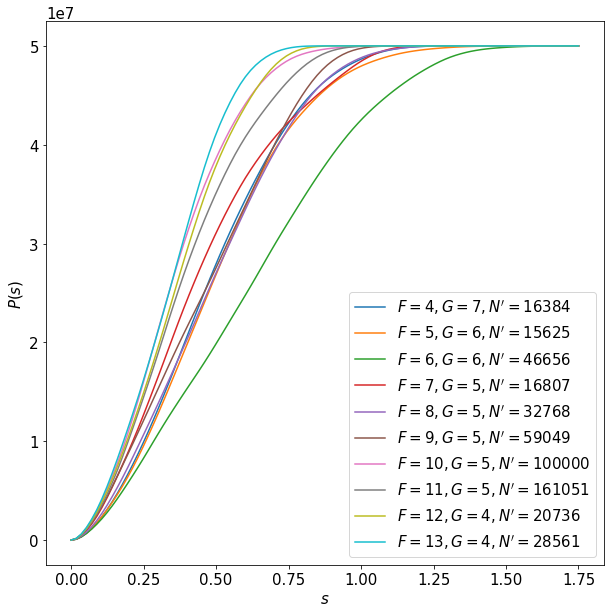

In [36]:
plt.figure(figsize=(10,10))
#plt.plot([], label='F=4', color="blue")  
#plt.plot([], label="F=5", color="red")  
for i,P_s in enumerate(P_s_list[:-2]):
    F=params[i][0]
    G=params[i][1]
    plt.plot(s_factors,P_s, label = r"$F={},G={},N'={}$".format(F,G,F**G))
plt.ylabel(r'$P(s)$')
plt.xlabel(r'$s$')
plt.legend()
#plt.rcParams.update({'font.size': 15})
plt.show()

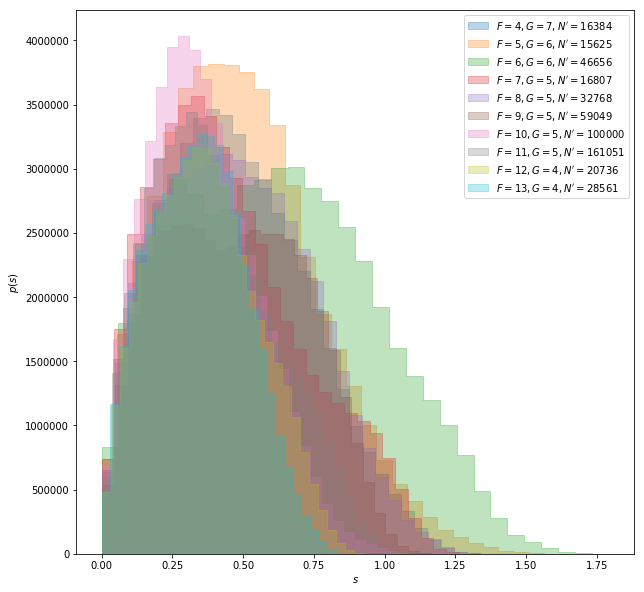

In [53]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)
#plt.plot([], label='F=4', color="blue")  
#plt.plot([], label="F=5", color="red")
for i,seps in enumerate(separations_list[:-2]):
    color = next(ax._get_lines.prop_cycler)["color"]
    F=params[i][0]
    G=params[i][1]
    plt.hist(seps, label = r"$F={},G={},N'={}$".format(F,G,F**G), bins=30, alpha=0.3,
         histtype='stepfilled', color=color,edgecolor=color)
plt.ylabel(r'$p(s)$')
plt.xlabel(r'$s$')
plt.legend()
plt.rcParams.update({'font.size': 1})
plt.show()

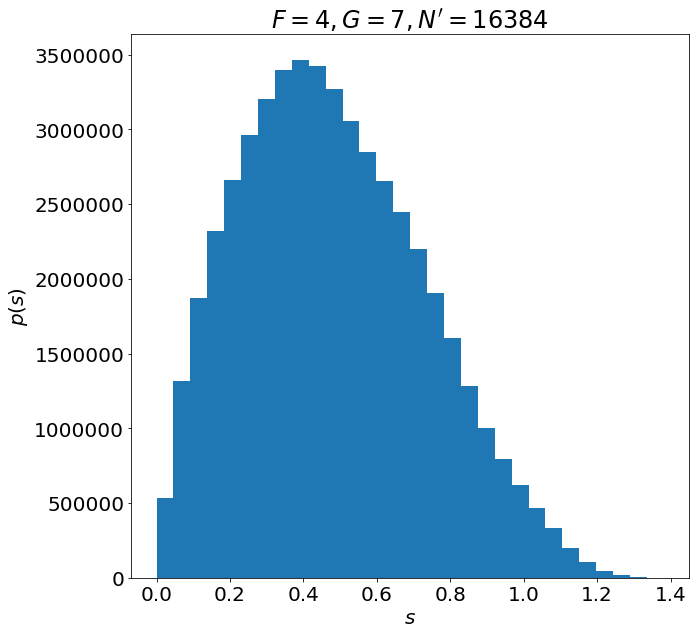

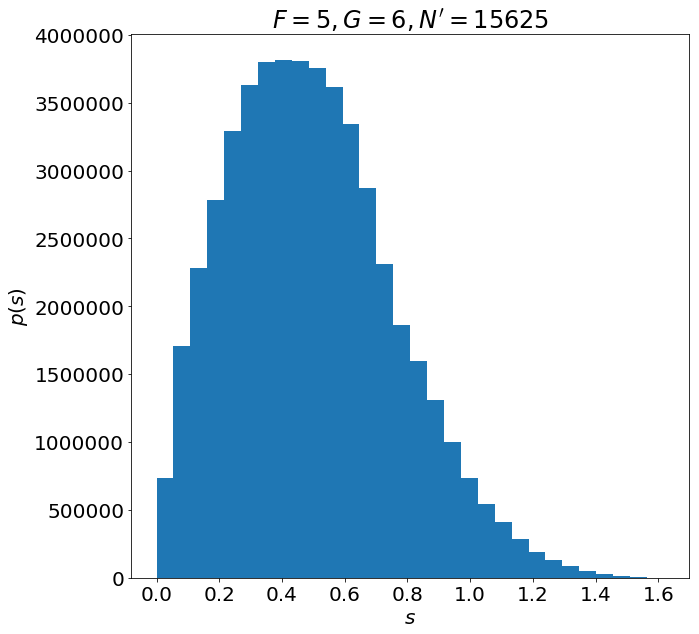

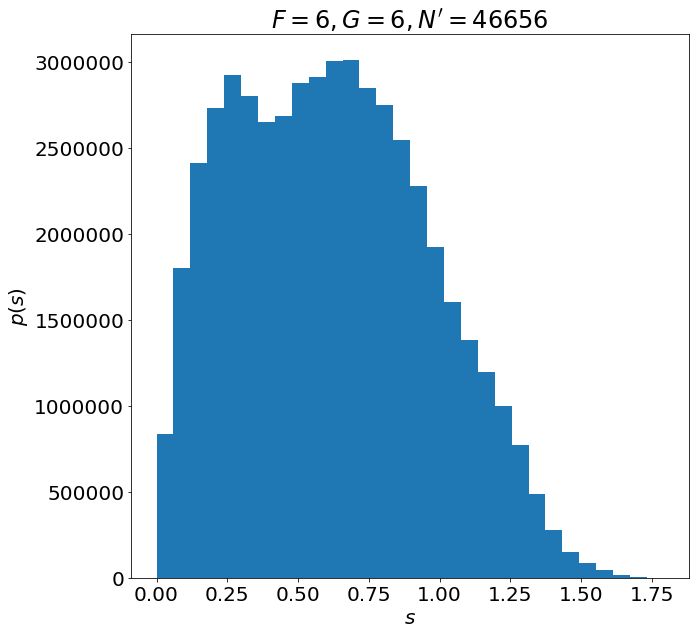

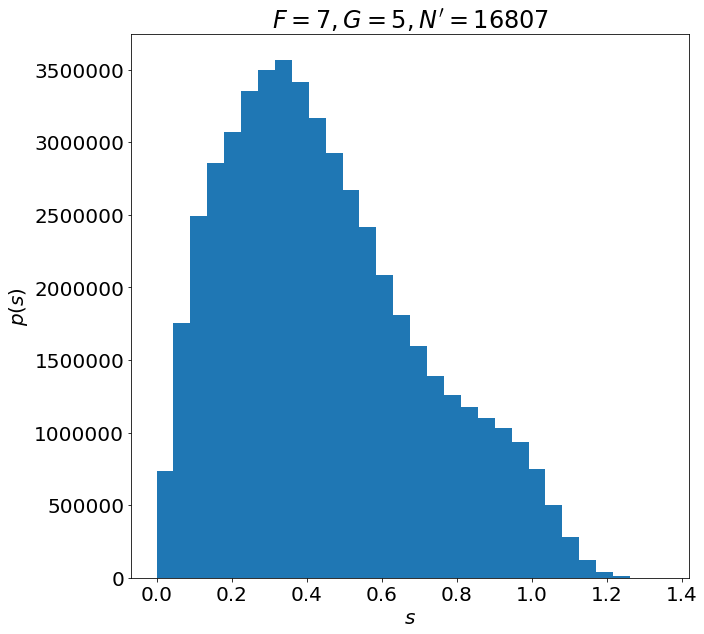

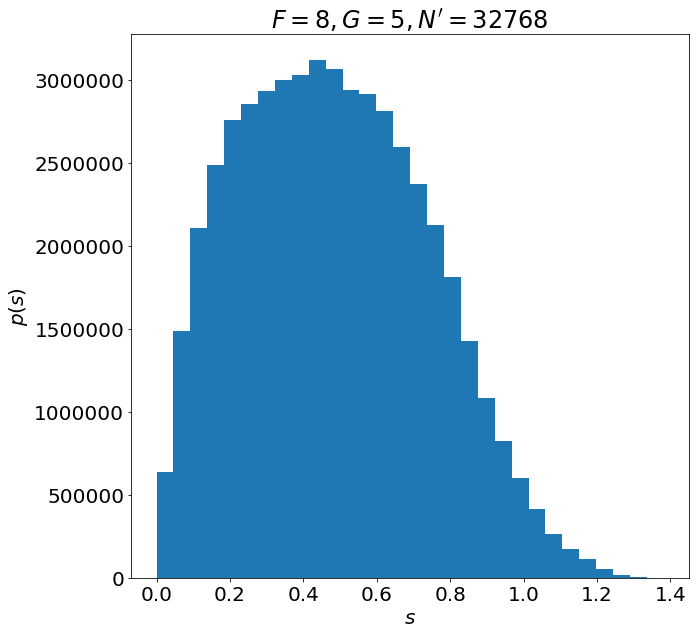

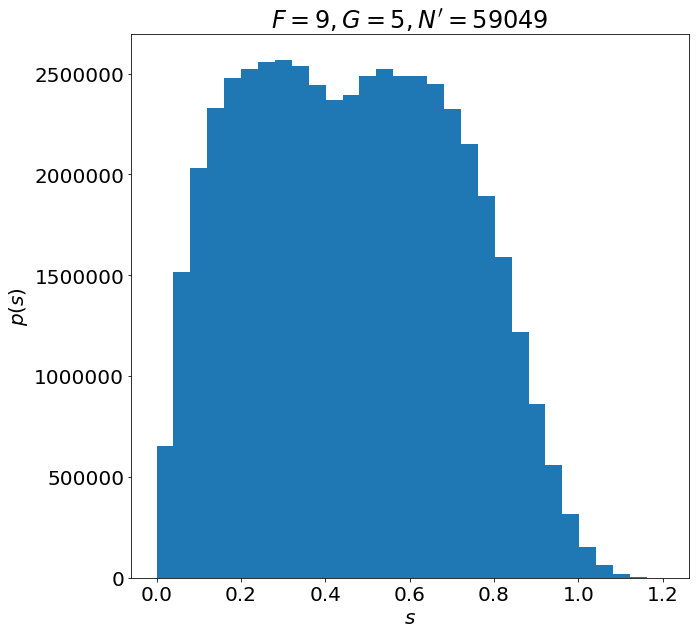

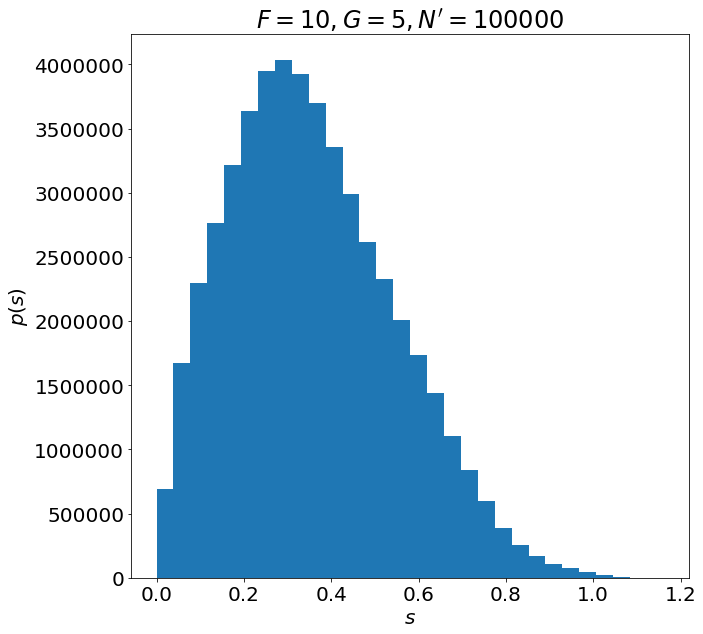

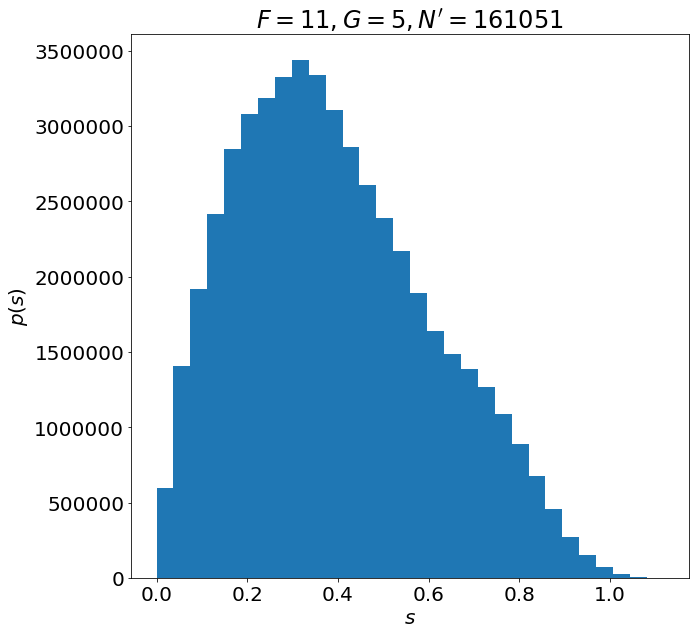

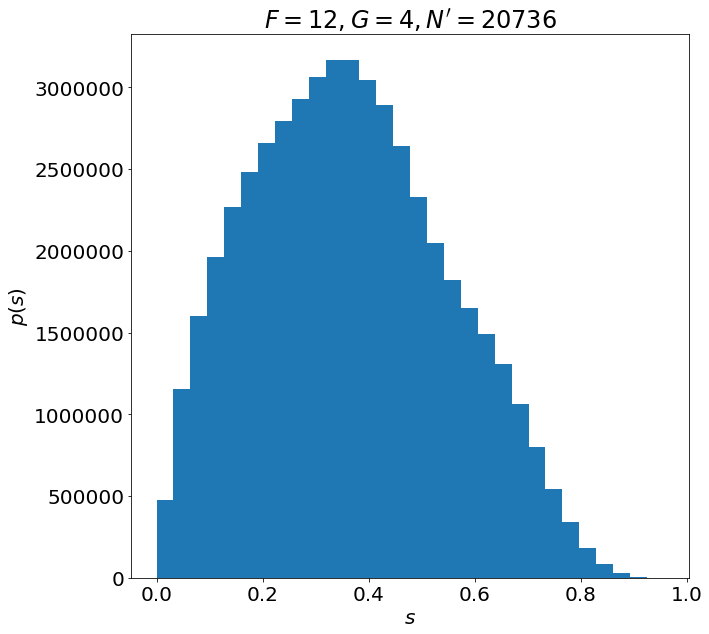

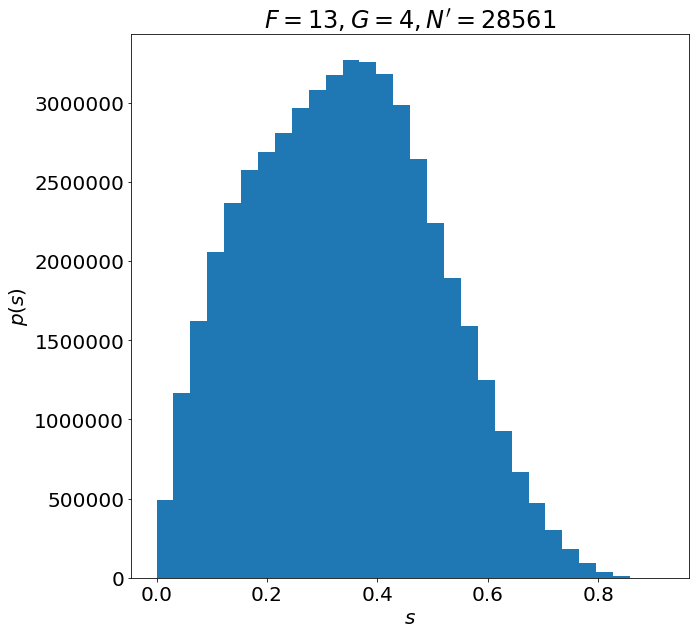

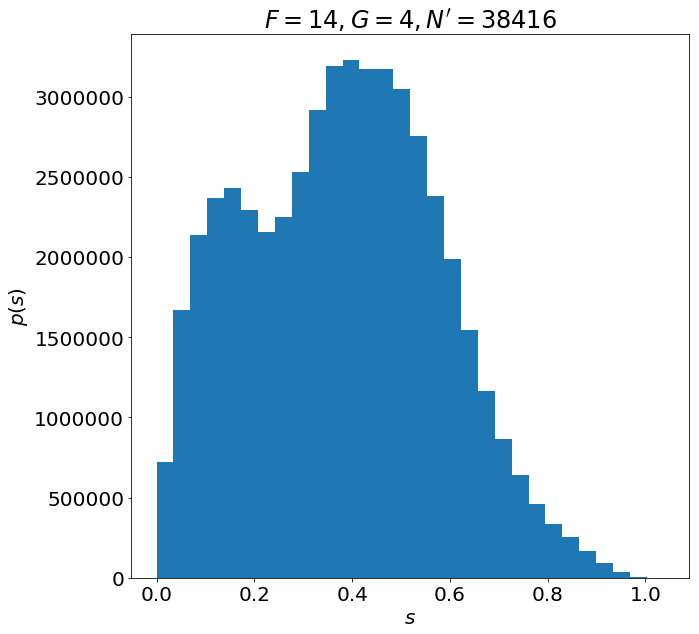

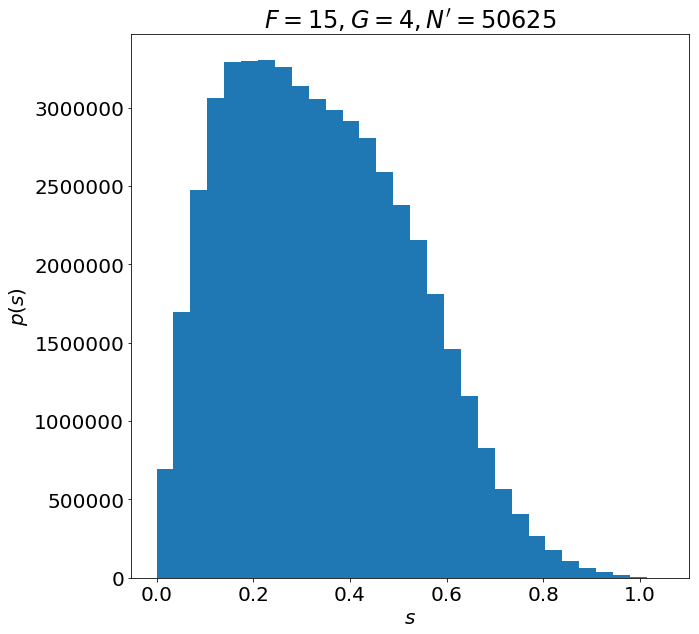

In [58]:
for i,seps in enumerate(separations_list):
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(10,10))
    F=params[i][0]
    G=params[i][1]
    plt.hist(seps, bins=30)
    plt.ylabel(r'$p(s)$')
    plt.xlabel(r'$s$')
    plt.title(r"$F={},G={},N'={}$".format(F,G,F**G))
    plt.show()